In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time
import copy
import os
%matplotlib inline

In [47]:
data_dir = 'transfer-data'
image_size = 224

In [48]:
train_dataset=datasets.ImageFolder(os.path.join(data_dir,'train'),
                                    transforms.Compose([
                                        transforms.RandomResizedCrop(image_size),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                    ])
                                    )

In [49]:
val_dataset = datasets.ImageFolder(os.path.join(data_dir,'val'),
                                   transforms.Compose([
                                       transforms.Resize(256),
                                       transforms.CenterCrop(image_size),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                   ])
                                   )

In [50]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=4,shuffle=True,num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=4,shuffle=True,num_workers=4)

num_classes = len(train_dataset.classes)
num_classes

2

In [51]:
use_cuda = torch.cuda.is_available()

dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.FloatTensor if use_cuda else torch.LongTensor

In [52]:
def imshow(inp, title= None):
    inp = inp.numpy().transpose((1,2,0))

    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    inp = std*inp + mean
    inp = np.clip(inp,0,1)

    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


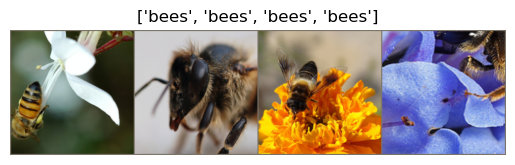

In [53]:
images,labels = next(iter(train_loader))
out = torchvision.utils.make_grid(images)
imshow(out,title=[train_dataset.classes[x] for x in labels])

In [54]:
depth = [4,8]

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(3,4,5,padding = 2)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(depth[0],depth[1],5,padding = 2)
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1],512)
        self.fc2 = nn.Linear(512,num_classes)
    
    def forward(self,x):
        x= F.relu(self.conv1(x))
        x= self.pool(x)
        x= F.relu(self.conv2(x))
        x= self.pool(x)

        x= x.view(-1,image_size // 4 * image_size // 4 * depth[1] )
        x = F.relu(self.fc1(x))
        x = F.dropout(x,training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x,dim = 1)
        return x


In [55]:
def rightness(predictions,labels):
    pred = torch.max(predictions.data,1)[1]
    rights = pred.eq(labels.data.view_as(pred)).sum()

    return rights,len(labels)

In [56]:
net = ConvNet()

net = net.cuda() if use_cuda else net
criterion  = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.0001,momentum=0.9)

In [57]:
def train_model(data,target):
    net.train()
    output = net(data)
    loss = criterion(output,target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    right = rightness(output,target)
    loss = loss.cpu() if use_cuda else loss
    return right,loss

def evaluation_model():
    net.eval()
    vals = []
    for data,target in val_loader:
        data,target = Variable(data,requires_grad=True),Variable(target)
        if use_cuda:
            data,target = data.cuda(),target.cuda()
        output = net(data)
        val =rightness(output,target)
        vals.append(val)
    return vals

def rightness(output,target):
    preds = output.data.max(dim = 1,keepdim = True)[1]
    return preds.eq(target.data.view_as(preds)).cpu().sum(),len(target)

In [58]:
record = []

num_epochs = 20
net.train(True)
best_model = net
best_r = 0.0
for epoch in range(num_epochs):
    train_rights=[]
    train_losses=[]
    
    for batch_idx,(data,target)in enumerate(train_loader):
        data,target=Variable(data),Variable(target)
        if use_cuda:
            data,target =data.cuda(),target.cuda()
        output=net(data)
        loss=criterion(output,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right=rightness(output,target)  
        train_rights.append(right)
        loss=loss.cpu() if use_cuda else loss
        train_losses.append(loss.data.numpy())

    train_r=(sum([tup[0] for tup in train_rights]),
             sum([tup[1] for tup in train_rights]))
    net.eval()
    test_loss=0
    correct=0
    vals=[]

    for data,target in val_loader:
        if use_cuda:
            data,target=data.cuda(), target.cuda()

        data,target=Variable(data,requires_grad=True),Variable(target)
        output=net(data)
        val=rightness(output,target)
        vals.append(val)
        
    val_r=(sum([tup[0] for tup in vals]),sum([tup[1] for tup in vals]))
    val_ratio=1.0*val_r[0].numpy()/val_r[1]
    if val_ratio>best_r:
        best_r=val_ratio
        best_model=copy.deepcopy(net)
        
    print('训练周期：{}\tLoss:{:.6f}\t训练正确率:{:.2f}%,校验正确率:{:.2f}%'.format(
        epoch,np.mean(train_losses),
        100.*train_r[0].numpy()/train_r[1],100.*val_r[0].numpy()/val_r[1]))
    record.append([np.mean(train_losses),1.*train_r[0].data.numpy()/train_r[1],
                   1.*val_r[0].data.numpy()/val_r[1]])
    

训练周期：0	Loss:0.691106	训练正确率:52.05%,校验正确率:45.75%
训练周期：1	Loss:0.685786	训练正确率:52.05%,校验正确率:47.06%
训练周期：2	Loss:0.689645	训练正确率:45.08%,校验正确率:52.29%
训练周期：3	Loss:0.680060	训练正确率:52.05%,校验正确率:50.33%
训练周期：4	Loss:0.675034	训练正确率:56.97%,校验正确率:51.63%
训练周期：5	Loss:0.670734	训练正确率:56.97%,校验正确率:56.21%
训练周期：6	Loss:0.671191	训练正确率:56.56%,校验正确率:54.25%
训练周期：7	Loss:0.664275	训练正确率:60.66%,校验正确率:56.21%
训练周期：8	Loss:0.669922	训练正确率:56.97%,校验正确率:56.86%
训练周期：9	Loss:0.658172	训练正确率:57.38%,校验正确率:56.21%
训练周期：10	Loss:0.651171	训练正确率:61.89%,校验正确率:58.82%
训练周期：11	Loss:0.646295	训练正确率:61.48%,校验正确率:59.48%
训练周期：12	Loss:0.635348	训练正确率:60.25%,校验正确率:57.52%
训练周期：13	Loss:0.637562	训练正确率:59.84%,校验正确率:57.52%
训练周期：14	Loss:0.624826	训练正确率:62.30%,校验正确率:59.48%
训练周期：15	Loss:0.639523	训练正确率:60.25%,校验正确率:60.13%
训练周期：16	Loss:0.610565	训练正确率:62.30%,校验正确率:59.48%
训练周期：17	Loss:0.632788	训练正确率:57.38%,校验正确率:62.75%
训练周期：18	Loss:0.603081	训练正确率:64.34%,校验正确率:62.75%
训练周期：19	Loss:0.600452	训练正确率:64.75%,校验正确率:63.40%


In [59]:
net.eval()
test_loss =0
correct=0
vals=[]
for data,target in val_loader:
    data,target =Variable(data,requires_grad=True),Variable(target)
    if use_cuda:
        data,target=data.cuda(),target.cuda()
    output=net(data)#将特征数据入网路，得到分类的输出
    val=rightness(output,target)#获得正确样本数以及总样本数
    vals.append(val)
rights =(sum([tup[0] for tup in vals]),sum([tup[1] for tup in vals]))
right_rate =1.0*rights[0].data.numpy()/rights[1]
right_rate

0.6339869281045751

Text(0, 0.5, 'Error Rate')

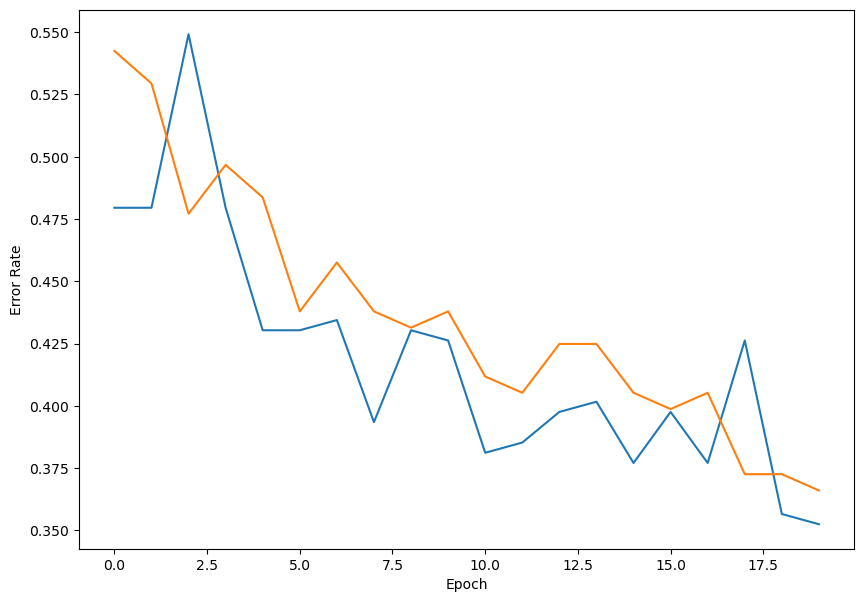

In [60]:
x=[x[0] for x in record]
y=[1-x[1] for x in record]
z=[1-x[2] for x in record]
plt.figure(figsize=(10,7))
plt.plot(y)
plt.plot(z)
plt.xlabel('Epoch')
plt.ylabel('Error Rate')

In [61]:
# torch.utils.models_zoo.load_url('http//labfile.oss.aliyuncs.com/course/1073/resnet18-5c106cde.pth')
net=models.resnet18(pretrained=True)
net=net.cuda() if use_cuda else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [62]:
num_ftrs=net.fc.in_features
net.fc=nn.Linear(num_ftrs,2)
net.fc=net.fc.cuda() if use_cuda else net.fc
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.0001,momentum=0.9) 

In [63]:
record=[]

num_epochs=20
net.train(True)
best_model=net
best_r=0.0
for epoch in range(num_epochs):
    train_rights=[]
    train_losses=[]
    for batch_idx,(data,target) in enumerate(train_loader):
        data,target=Variable(data),Variable(target)
        if use_cuda:
            data,target=data.cuda(),target.cuda()
        output=net(data)
        loss=criterion(output,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right=rightness(output,target)
        train_rights.append(right)
        loss=loss.cpu() if use_cuda else loss
        train_losses.append(loss.data.numpy())

    train_r=(sum([tup[0] for tup in train_rights]),
             sum([tup[1] for tup in train_rights]))
    net.eval()
    test_loss=0
    correct=0
    vals=[]

    for data,target in val_loader:
        if use_cuda:
            data,target=data.cuda(),target.cuda()
        data,target=Variable(data,requires_grad=True),Variable(target)
        output=net(data)
        val=rightness(output,target)
        vals.append(val)

    val_r=(sum([tup[0] for tup in vals]),sum([tup[1] for tup in vals]))
    val_ratio=1.0*val_r[0].numpy()/val_r[1]

    if val_ratio>best_r:
        best_r=val_ratio
        best_model=copy.deepcopy(net)
        
    print('训练周期:{}\tLoss:{:.6f}\t训练正确率:{:.2f}%,校验正确率:{:.2f}%'.format(
        epoch,np.mean(train_losses),
        100.*train_r[0].numpy()/train_r[1],100.*val_r[0].numpy()/val_r[1]))
    record.append([np.mean(train_losses),1.*train_r[0].data.numpy()/train_r[1],
                   1.*val_r[0].data.numpy()/val_r[1]])


训练周期:0	Loss:0.624581	训练正确率:63.52%,校验正确率:76.47%
训练周期:1	Loss:0.351795	训练正确率:87.70%,校验正确率:90.20%
训练周期:2	Loss:0.175692	训练正确率:93.44%,校验正确率:94.12%
训练周期:3	Loss:0.178283	训练正确率:92.21%,校验正确率:94.12%
训练周期:4	Loss:0.129555	训练正确率:95.90%,校验正确率:93.46%
训练周期:5	Loss:0.136132	训练正确率:94.67%,校验正确率:94.77%
训练周期:6	Loss:0.144967	训练正确率:93.85%,校验正确率:92.81%
训练周期:7	Loss:0.143914	训练正确率:94.26%,校验正确率:94.12%
训练周期:8	Loss:0.093558	训练正确率:97.13%,校验正确率:94.77%
训练周期:9	Loss:0.075583	训练正确率:96.72%,校验正确率:94.77%
训练周期:10	Loss:0.110709	训练正确率:93.85%,校验正确率:89.54%
训练周期:11	Loss:0.170555	训练正确率:91.80%,校验正确率:85.62%
训练周期:12	Loss:0.107263	训练正确率:95.90%,校验正确率:94.77%
训练周期:13	Loss:0.069880	训练正确率:97.95%,校验正确率:96.08%
训练周期:14	Loss:0.072832	训练正确率:96.72%,校验正确率:96.08%
训练周期:15	Loss:0.098742	训练正确率:95.90%,校验正确率:92.81%
训练周期:16	Loss:0.070915	训练正确率:97.54%,校验正确率:94.77%
训练周期:17	Loss:0.102823	训练正确率:95.90%,校验正确率:93.46%
训练周期:18	Loss:0.089968	训练正确率:97.13%,校验正确率:91.50%
训练周期:19	Loss:0.062817	训练正确率:97.54%,校验正确率:95.42%


Text(0, 0.5, 'Error Rate')

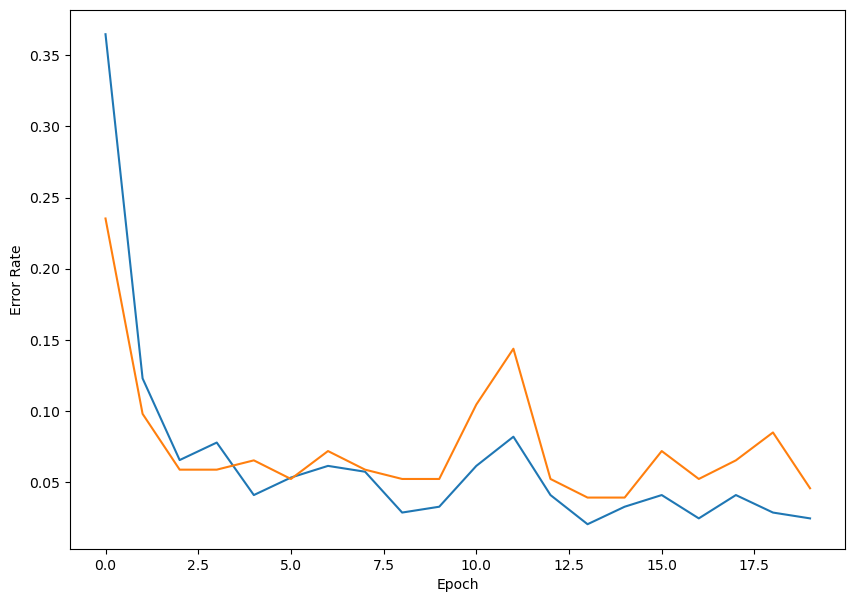

In [64]:
x=[x[0] for x in record]
y=[1-x[1] for x in record]
z=[1-x[2] for x in record]
#plt.plot(x)
plt.figure(figsize=(10,7))
plt.plot(y)
plt.plot(z)
plt.xlabel('Epoch')
plt.ylabel('Error Rate')

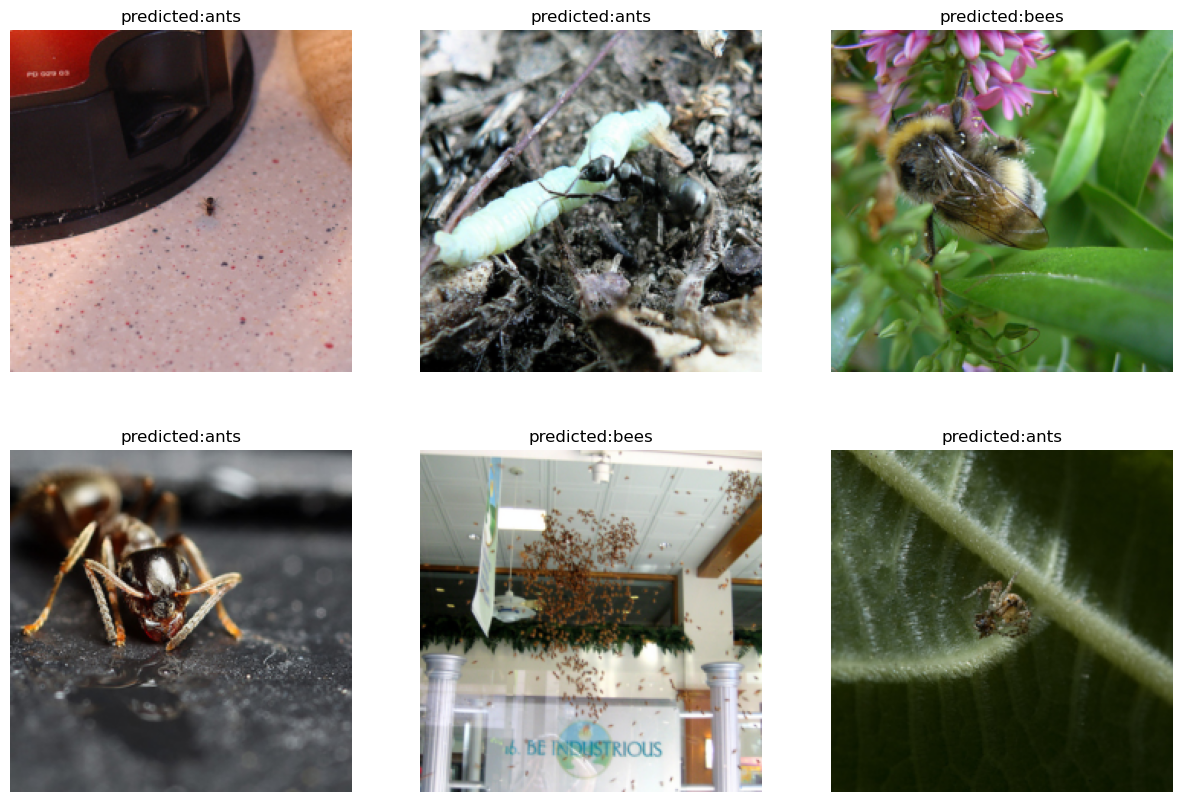

In [65]:
def visualize_model(model,num_images=6):
    images_so_far = 0
    fig = plt.figure(figsize=(15,10))
    for i, data in enumerate(val_loader):
        inputs,labels = data
        inputs,labels = Variable(inputs),Variable(labels)
        if use_cuda:
            inputs,labels = inputs.cuda(),labels.cuda()
        outputs = model(inputs)
        _, preds=torch.max(outputs.data,1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        
        # for j in range(inputs.size()[0]):
        #     images_so_far += 1
        #     ax=plt.subplot(2, num_images//2,images_so_far)
        #     ax.axis('off')
        #     ax.set_title('predicted:{}'.format(val_dataset.classes[preds[j]]))
        #     imshow(data[0][j])

        for j in range(inputs.size()[0]):
            images_so_far += 1
            plt.subplot(2, num_images//2,images_so_far)
            plt.axis('off')
            plt.title('predicted:{}'.format(val_dataset.classes[preds[j]]))
            inp=data[0][j].numpy().transpose((1,2,0))
            mean = np.array([0.485,0.456,0.406])
            std = np.array([0.229,0.224,0.225])
            inp = std*inp + mean
            inp = np.clip(inp,0,1)
            plt.imshow(inp)

            if images_so_far ==num_images:
                return
            
visualize_model(net)
plt.ioff()
plt.show()

In [66]:
#4.5固定值模式
net = torchvision.models.resnet18(pretrained=True)
net=net.cuda() if use_cuda else net
for param in net.parameters():
    param.requires_grad=False

num_ftrs=net.fc.in_features
net.fc=nn.Linear(num_ftrs,2)
net.fc=net.fc.cuda() if use_cuda else net.fc

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.fc.parameters(),lr=0.001,momentum=0.9)


In [67]:
record=[]

num_epochs=20
net.train(True)
best_model=net
best_r=0.0
for epoch in range(num_epochs):
    train_rights=[]
    train_losses=[]
    for batch_idx,(data,target) in enumerate(train_loader):
        data,target=Variable(data),Variable(target)
        if use_cuda:
            data,target=data.cuda(),target.cuda()
        output=net(data)
        loss=criterion(output,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right=rightness(output,target)
        train_rights.append(right)
        loss=loss.cpu() if use_cuda else loss
        train_losses.append(loss.data.numpy())
    
    train_r=(sum([tup[0] for tup in train_rights]),
             sum([tup[1] for tup in train_rights]))
    net.eval()
    test_loss=0
    correct=0
    vals=[]
    
    for data,target in val_loader:
        if use_cuda:
            data,target=data.cuda(),target.cuda()
        data,target =Variable(data,requires_grad=True),Variable(target)
        output=net(data)
        val=rightness(output,target)
        vals.append(val)

    val_r=(sum([tup[0] for tup in vals]),sum([tup[1] for tup in vals]))
    val_ratio=1.0*val_r[0].numpy()/val_r[1]

    if val_ratio>best_r:
        best_r=val_ratio
        best_model=copy.deepcopy(net)

    print('训练周期:{}\tLoss:{:.6f}\t训练正确率:{:.2f}%,校验正确率:{:.2f}%'.format(
        epoch,np.mean(train_losses),
        100.*train_r[0].numpy()/train_r[1],100.*val_r[0].numpy()/val_r[1]
    ))

    record.append([np.mean(train_losses),1.*train_r[0].numpy()/train_r[1],
                   1.*val_r[0].numpy()/val_r[1]])

训练周期:0	Loss:0.520400	训练正确率:69.26%,校验正确率:89.54%
训练周期:1	Loss:0.214119	训练正确率:91.39%,校验正确率:90.85%
训练周期:2	Loss:0.183247	训练正确率:92.62%,校验正确率:93.46%
训练周期:3	Loss:0.226830	训练正确率:88.93%,校验正确率:86.93%
训练周期:4	Loss:0.140807	训练正确率:93.44%,校验正确率:92.81%
训练周期:5	Loss:0.118054	训练正确率:95.90%,校验正确率:92.16%
训练周期:6	Loss:0.138595	训练正确率:94.67%,校验正确率:94.77%
训练周期:7	Loss:0.127718	训练正确率:94.26%,校验正确率:93.46%
训练周期:8	Loss:0.114810	训练正确率:93.44%,校验正确率:94.12%
训练周期:9	Loss:0.121461	训练正确率:95.49%,校验正确率:94.12%
训练周期:10	Loss:0.106182	训练正确率:96.72%,校验正确率:92.16%
训练周期:11	Loss:0.080661	训练正确率:96.31%,校验正确率:94.12%
训练周期:12	Loss:0.096118	训练正确率:96.72%,校验正确率:94.12%
训练周期:13	Loss:0.073769	训练正确率:96.72%,校验正确率:94.12%
训练周期:14	Loss:0.138894	训练正确率:93.03%,校验正确率:94.12%
训练周期:15	Loss:0.149256	训练正确率:93.85%,校验正确率:94.12%
训练周期:16	Loss:0.097592	训练正确率:95.90%,校验正确率:94.12%
训练周期:17	Loss:0.080443	训练正确率:97.13%,校验正确率:94.12%
训练周期:18	Loss:0.107887	训练正确率:96.72%,校验正确率:94.12%
训练周期:19	Loss:0.097883	训练正确率:95.49%,校验正确率:94.12%


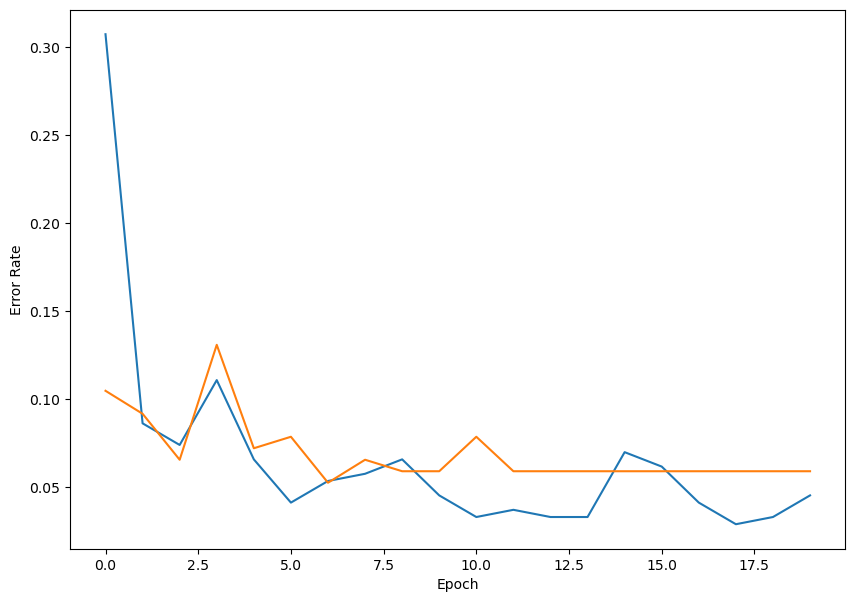

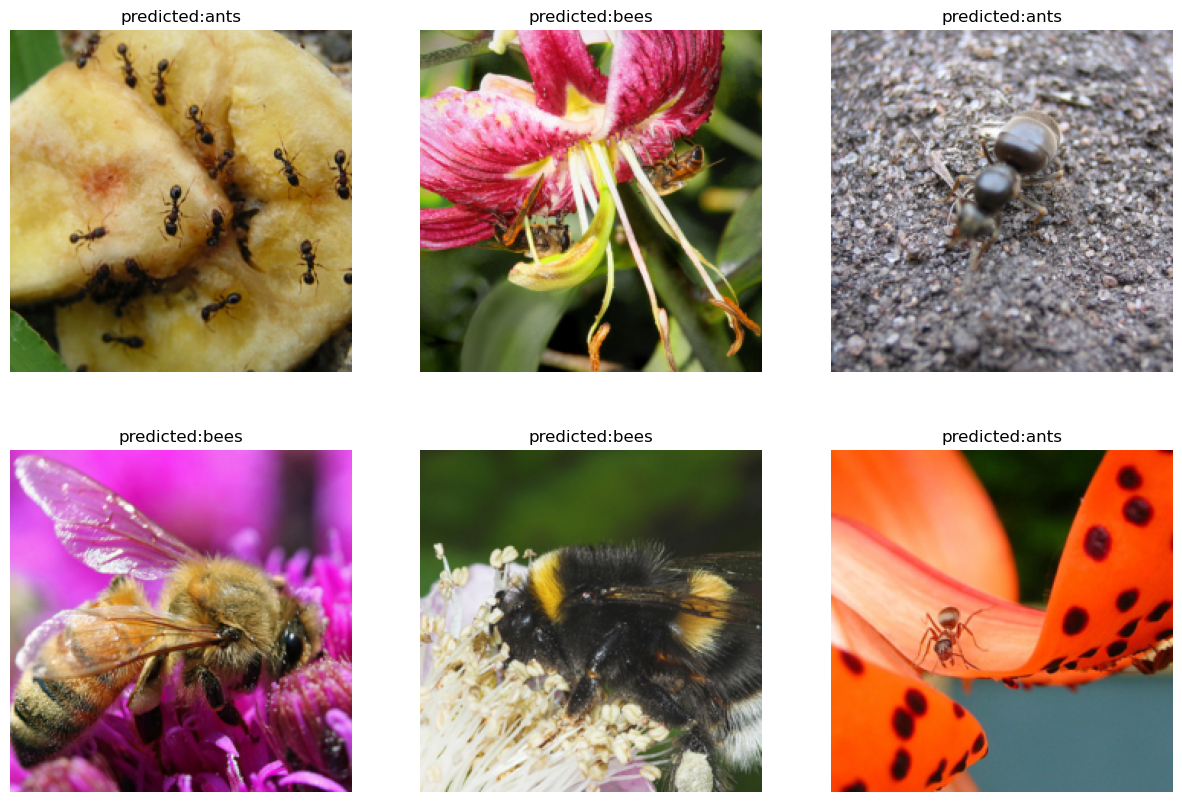

In [68]:
x=[x[0] for x in record]
y=[1-x[1] for x in record]
z=[1-x[2] for x in record]
plt.figure(figsize=(10,7))
plt.plot(y)
plt.plot(z)
plt.xlabel('Epoch')
plt.ylabel('Error Rate')

visualize_model(best_model)
plt.ioff()
plt.show()